# Markdown Processing Personal Project
## Introduction
Over the past few years I have been using the popular WYSIWYG (what you see is what you get) Markdown editor, Obsidian, to keep track of medically useful information about myself. This has been useful to check for example whether I have taken my medication today or when I last ate.

### The usefulness of the Obsidian Vault~
An Obsidian vault is essentially a library of markdown files that can be used for whatever purpose the user desires. By default, Obsidian follows standard Markdown format and provides useful tools through core and community plugins such as `Backlinks`, `Templates` and `Daily Notes` which I used extensively when creating the source dataset for this project, along with a `Graph View` which gives a visual representation of how the vault files link together.


> 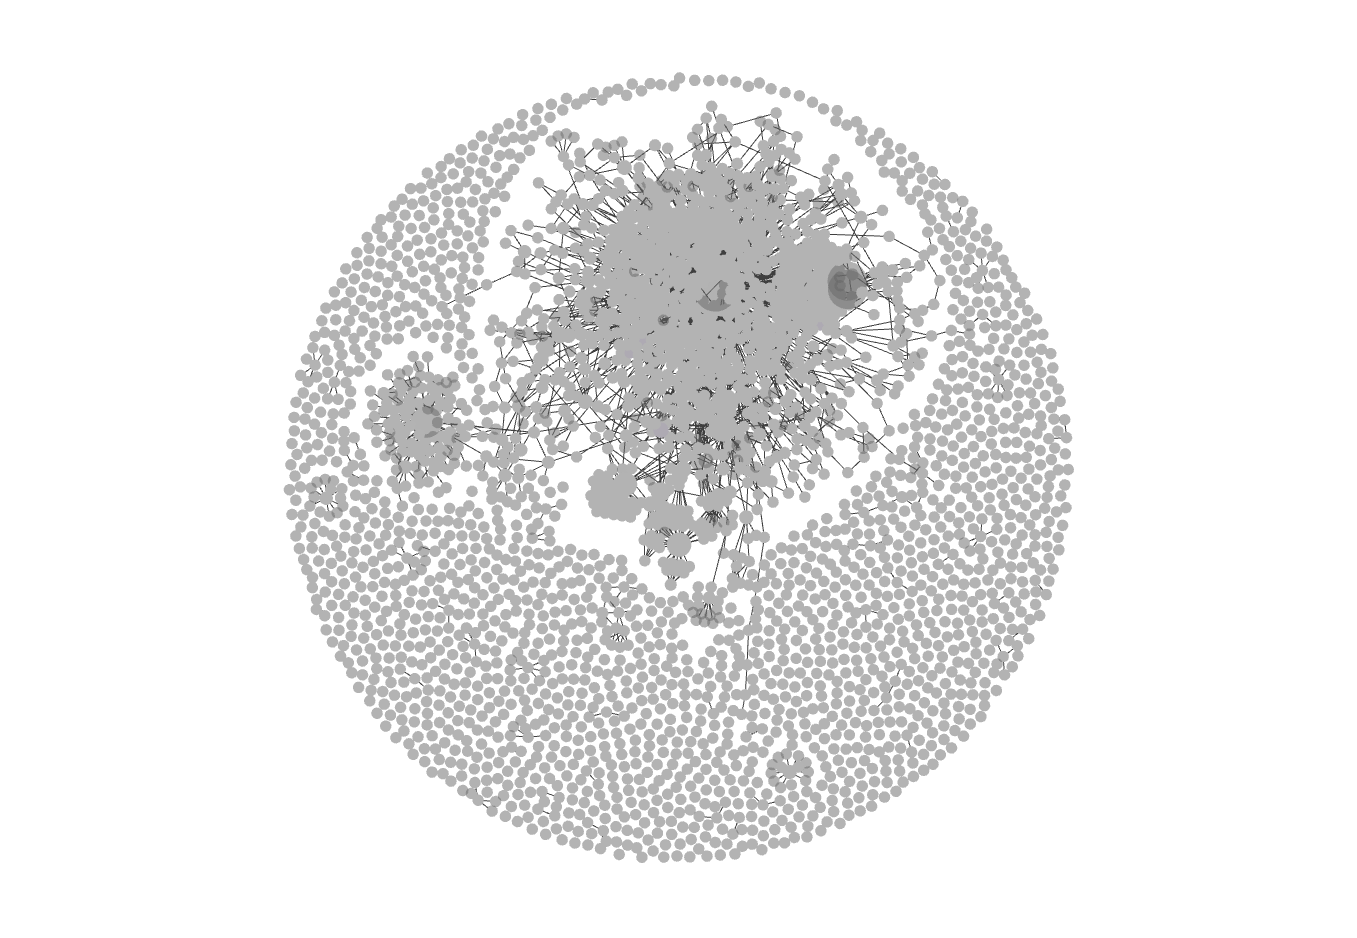



My plan is to capitalise on the skills learnt through this Just-IT Data Skills Bootcamp in order to concentrate the source dataset, extracting three key tables (medication, diet, sleep quality) of consolidated information for further analysis.
Draft plan
- Extract
- Transform
- Load
- Verify (Integrity + Validity)
- Analyse: can analyse how long from serving did I start eating, how long to finish (any relationship between longer between serving and starting, and length taken)
- Visualise


### Extract
There are over 1500 markdown files in my `'mobile-notes-dataset'` from which to extract data, My process and approach has evolved since the beginning, and thus there are different templates used and information to extract between different time periods. This means that not only will I have to implement a specific data extraction script for each area data is tracked for, but that those scripts must be able to handle the different forms used between templates without breaking or giving faulty data.

### Transform & Load
Once the data has been succesfully extracted from the 1500~ markdown files into just three csv files, `medication.csv`, `wake_time.csv` and `dietary.csv`, these tables can then be imported into either Excel or PowerBI for transform the extracted data into a usable form.
Some of the transformations that I will need to do include:
- filter/delete rows with blank/null values for essential fields
- handle non-standard inputs for `time` field and `dosage` field in medication table
  - `time` field contains multiple csv delimmited times
    - duplicate row for each time listed
    - ensure duplicated rows have correct dosages, sometimes 1/2 or 3/2 initial
  - `dosage` field contains units, non-standard measurements such as `1 tablet`
    - handle dosage multiplication such that only numerical value multiplied
    - handle units, either pull into column if can consolidate or find other solution
- continously verify data validity and integrity against expectations, until all non-standard values are handled
- consider filling in missing meal times using images
  - consider how to handle meals with only times vs ones with all ingredients

At this stage it will become clear what other transformations need to be carried out before Loading the data into PowerBI or Tableau for visualisation purposes.


## Loading (then extracting) the Data from the markdown `mobile-notes-dataset`
The first step in my project is to load the markdown files from their non-standard folder structure, handling duplicates and empty templates, ensuring all files in the dataset are utilised and imported for use in further programmatic handling.
### File Handling Approach

In [1]:
import os
import re
import pandas as pd
from pathlib import Path

# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive/')

# Dataset Directory
mobile_notes_directory = '/content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset' # All of my markdown files in various subdirectories

# List and Filter the markdown files
def list_md_files(folder):
    folder_path = Path(folder)
    return [f for f in folder_path.rglob("*.md")
            if f.is_file() and 'template' not in f.name.lower()]

print(mobile_notes_directory)
#print(list_md_files(mobile_notes_directory))

# --- moved below
# # Iterate through markdown files for extraction
# test = 0
# for file in list_md_files(mobile_notes_directory):
#     full_path = os.path.join(mobile_notes_directory, file)
#     print(full_path)
#     test += 1
#     if test == 5: break
#     # open file, parse contents, extract meds/wake info

# # Date Extraction and Folder Context - capture folder name as date context while processing
# def extract_date_from_path(file_path):
#     path_obj = Path(file_path)
#     # assuming folder structure meds_folder/YYYY-MM/filename.md
#     folder_date = path_obj.parent.name
#     return folder_date

# # Reading File Contents
# # open files safely with encoding as needed
# with open(full_path, 'r', encoding='utf-8') as f:
#     contents = f.read()
#     # print("checking file at", full_path)
#     # print(contents)
# # Process contents with regex or parsing logic to extract meds/wake/diet times.


Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset


## Defining communal methods
Here I define the methods that are used across all processing steps:
- `extract_date(filename)`
  - My files are named in a constant way, using `YYYY-MM-DD` date format and thus regex `r'(\d{4}-\d{2}-\d{2})'` is used to extract
- `find_section_positions(content, header_regex)`
  - My templates are split into sections by headers, wake times under 'Wake'/'Sleep' header, medication details under 'Medication' header, and diet information and timings under 'Food' Header.
  - So by defining a specific regex per header, I can programmatically seperate the correct section of each markdown file for data extraction
- `extract_table_lines(lines, start_idx)`
    - After each section has been seperated, the lines then need to be cleaned such that any formatting lines or non-table data isn't carried forward into the processing steps.
- `parse_markdown_table(table_lines)`
  - Finally, after the lines containing markdown tables are identified, these must be processed to extract the values of each cell, per column, before being combined to return the rows to be added to the dataset.

In [2]:
from datetime import datetime

# # Iterate through markdown files for extraction
# test = 0
# for file in list_md_files(mobile_notes_directory):
#     full_path = os.path.join(mobile_notes_directory, file)
#     print(full_path)
#     test += 1
#     if test == 5: break
#     # open file, parse contents, extract meds/wake info

# # Date Extraction and Folder Context - capture folder name as date context while processing
# def extract_date_from_path(file_path):
#     path_obj = Path(file_path)
#     # assuming folder structure meds_folder/YYYY-MM/filename.md
#     folder_date = path_obj.parent.name
#     return folder_date

# Reading File Contents
# # open files safely with encoding as needed
# with open(full_path, 'r', encoding='utf-8') as open_file:
#     contents = open_file.read()
#     # print("checking file at", full_path)
#     # print(contents)

def full_path(mobile_notes_directory, file):
  return os.path.join(mobile_notes_directory, file)

def read_file(full_path):
  with open(full_path, 'r', encoding='utf-8') as open_file:
    return open_file.read()

# Extract date from filename and return datetime object
def extract_date(filename):
    patterns = [r'(\d{4}-\d{2}-\d{2})', r'(\d{2}-\d{2}-\d{4})']
    for pattern in patterns:
        pattern_match = re.search(pattern, filename)
        if pattern_match:
            matching_dataset = pattern_match.group(1)
            try:
                if '-' in matching_dataset and len(matching_dataset.split('-')[0]) == 4:
                    return datetime.strptime(matching_dataset, '%Y-%m-%d').date().isoformat()
                else:
                    return datetime.strptime(matching_dataset, '%d-%m-%Y').date().isoformat()
            except Exception:
                continue
    return 'UNKNOWN_DATE'

# Return list of (line_index, header_text) where markdown headers matching regex found
def find_section_positions(content, header_regex):
    lines = content.splitlines()
    # print("header_regex:", header_regex)
    positions = []
    for idx, line in enumerate(lines):
        if re.match(header_regex, line):
            positions.append((idx, line.strip()))
    return positions

# Extract consecutive markdown table lines starting after start_idx
def extract_table_lines(lines, start_idx, end_idx = None):
    table_lines = []
    # print("Extracting the table lines from line", start_idx, "to line", end_idx)
    # print("from:\n", lines)
    if end_idx:
      for line in lines[start_idx:end_idx]:
          if not line.strip().startswith('|'):
              continue
          # print("line:", line)
          table_lines.append(line)
    else:
      for line in lines[start_idx:]:
          if not line.strip().startswith('|'):
              continue
          # print("line:", line)
          table_lines.append(line)
    return table_lines

# Parse markdown table lines to extract data rows in dictionary format
def parse_markdown_table(table_lines):
    if len(table_lines) < 2:
        return []
    headers = [h.strip() for h in table_lines[0].strip('| ').split('|')]
    # print("headers", headers)
    data_rows = []
    for line in table_lines[2:]:
        # print("parsing line", line)
        if not line.startswith('|'):
            break
        cells = [c.strip() for c in line.strip('| ').split('|')]
        # print("cells", cells)
        if len(cells) == len(headers):
            # print(dict(zip(headers, cells)))
            data_rows.append(dict(zip(headers, cells)))
    return data_rows


def get_file_info(file):
    file_path = Path(file)
    folder = file_path.parent.name
    filename = file_path.name
    date = extract_date(filename)
    content = file_path.read_text(encoding='utf-8')
    lines = content.splitlines()
    # print(date, filename, folder, content)
    # print(lines)
    return date, filename, folder, content, lines


# Process contents with regex or parsing logic to extract meds/wake/diet times.
def process_file_headers(date, filename, folder, content, lines):

    # Find Wake & Sleep header lines
    wake_headers = find_section_positions(content, r'^#{1,3}\s*Wake\b')
    # if wake_headers:
    #   print("wake_headers", wake_headers)
    sleep_headers = find_section_positions(content, r'^#{1,3}\s*Sleep\b')
    # if wake_headers or sleep_headers:
    #  print("wake_headers", wake_headers, "sleep_headers", sleep_headers)

    # Find Medication header lines
    medication_headers = find_section_positions(content, r'^#{1,3}\s*Medication\b')
    # print("medication_headers", medication_headers)

    # Find Diet header lines
    food_headers = find_section_positions(content, r'^#{1,3}\s*Food\b')
    # print("food_headers", food_headers)

    # return wake_headers, medication_headers, food_headers
    return wake_headers, sleep_headers, medication_headers, food_headers

# Files for Test Cases
test_case_full = "/content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset/mobile-notes-backup-2025-11-30/Daily Notes/2025-11/2025-11-30.md"

print("test case:", test_case_full, "\nheaders:", process_file_headers(*get_file_info(test_case_full))) # need tuple unpacking to pass positional arguments

# print("check tuple xplode:", *get_file_info(test_case_full))


test case: /content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset/mobile-notes-backup-2025-11-30/Daily Notes/2025-11/2025-11-30.md 
headers: ([(43, '## Wake')], [(45, '## Sleep')], [(51, '# Medication')], [(110, '# Food')])


## Extracting the Wake Times from dataset
extracting the useful information, file by file using regex

In [8]:

def extract_wake_times(section_headers, file_info):
  date = file_info[0]
  filename = file_info[1]
  folder = file_info[2]
  lines = file_info[4]

  wake_headers = section_headers[0]
  wake_rows = []
  # missing_wakes = 0

  if wake_headers:
      # Use first Wake header position
      # print("wake_headers", wake_headers)
      # print("wake_headers[0]", wake_headers[0])
      # print("wake_headers[0][0]", wake_headers[0][0])
      wake_idx, wake_header_text = wake_headers[0]

      # Find next Sleep header after Wake
      # sleep_headers = find_section_positions(content, r'^#{1,3}\s*Sleep\b')
      sleep_headers = section_headers[1]
      sleep_idx = None
      for idx, header in sleep_headers:
          if idx > wake_idx:
              sleep_idx = idx
              break

      if sleep_idx is None:
          print(f"No Sleep section found after Wake in {filename}")
      else:
          # Extract sleep table lines
          # print("Extracting wake times from file...")
          table_lines = extract_table_lines(lines, sleep_idx)
          # print("\nsleep_idx", sleep_idx, "\nlines", lines, "\ntable_lines", table_lines)
          if not table_lines:
              print(f"No table found in Sleep section in {filename}")
          else:
              sleep_data = parse_markdown_table(table_lines)
              for row in sleep_data:
                  row.update({'date': date, 'filename': filename, 'folder': folder, 'section_type': 'Wake+Sleep'})
              wake_rows.extend(sleep_data)

  # else:
      # print(f"No Wake section found in {filename}")
      # missing_wakes += 1
  return wake_rows

extract_wake_times(process_file_headers(*get_file_info(test_case_full)),get_file_info(test_case_full))


[{'Sleep': '~',
  'Wake': '14:45',
  'Time': '',
  'Quality': 'Decent',
  'date': '2025-11-30',
  'filename': '2025-11-30.md',
  'folder': '2025-11',
  'section_type': 'Wake+Sleep'}]

# Extracting Medication Details from the Dataset

In [9]:
def extract_med_times(section_headers, file_info):
  date = file_info[0]
  filename = file_info[1]
  folder = file_info[2]
  lines = file_info[4]

  medication_headers = section_headers[2]
  med_rows = []

  if medication_headers:
    # print(medication_headers)
    for med_idx, med_header_text in medication_headers:
        # Find med subsections (Prescribed/OTC)
        subsections = []
        for i in range(med_idx+1, len(lines)):
            line = lines[i]
            # print("line:", line)
            if re.match(r'^#{2,3}\s*(Prescribed|OTC|Medication)', line, re.I):
                subsections.append((i, line.strip()))
                # print("append:", line.strip())
            elif re.match(r'^#{1}\s+\S+', line):  # next main header blocks med section
                # print(line)
                # print("next main header blocks med section")
                break
        if subsections:
            table_length = subsections[1][0] - subsections[0][0]
            for sub_idx, sub_header in subsections:
                # print("\nsubsections", subsections, "\n\nsub_idx", sub_idx, "\nsub_header", sub_header)
                # print("Extracting", sub_header, "medication times from file...")
                table_lines = extract_table_lines(lines, sub_idx, sub_idx+table_length)
                # print("sub table lines:", table_lines)
                parsed = parse_markdown_table(table_lines)
                # print("parsed sub table lines:", parsed)
                section_type = 'Medication'
                lsub = sub_header.lower()
                if 'prescribed' in lsub:
                    section_type = 'Prescription'
                elif 'otc' in lsub:
                    section_type = 'OTC'
                for row in parsed:
                    row.update({'date': date, 'filename': filename, 'folder': folder, 'section_type': section_type})
                med_rows.extend(parsed)
        else:
            # fallback: parse medication table right under medication header
            table_lines = extract_table_lines(lines, med_idx, med_idx+7)
            # print("fallback table lines:", table_lines)
            parsed = parse_markdown_table(table_lines)
            for row in parsed:
                row.update({'date': date, 'filename': filename, 'folder': folder, 'section_type': 'Medication'})
            med_rows.extend(parsed)
    return med_rows

extract_med_times(process_file_headers(*get_file_info(test_case_full)),get_file_info(test_case_full))

[{'Time': '17:09',
  'Medication': 'Ritalin IR',
  'Dosage': '5mg',
  'date': '2025-11-30',
  'filename': '2025-11-30.md',
  'folder': '2025-11',
  'section_type': 'Prescription'},
 {'Time': '17:09',
  'Medication': 'Fexofenadine',
  'Dosage': '120mg',
  'date': '2025-11-30',
  'filename': '2025-11-30.md',
  'folder': '2025-11',
  'section_type': 'OTC'}]

# Extracting Meal Details from the Dataset
Left for a future project iteration, priority is skills demonstration.

# Outputting to CSV

In [10]:
output_directory = "/content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset/Output/"
all_wake = []
all_med = []
files = list_md_files(mobile_notes_directory)
print(f"Processing {len(files)} markdown files...")

# test_counter = 0 # remove when working
for file in files:
    if 'template' in file.name.lower() or 'test' in file.name.lower():
        continue
    # test_counter += 1 # remove when working
    wake = extract_wake_times(process_file_headers(*get_file_info(file)),get_file_info(file))
    med = extract_med_times(process_file_headers(*get_file_info(file)),get_file_info(file))
    if wake:
        # print(f"Extracted {len(wake)} Wake+Sleep rows from {file.name}")
        all_wake.extend(wake)
    if med:
        # print(f"Extracted {len(med)} Medication rows from {file.name}")
        all_med.extend(med)
    # if test_counter > 200: # remove when working
    #   break

if all_wake:
    df_wake = pd.DataFrame(all_wake)
    df_wake.drop_duplicates(subset=['date', 'filename'], inplace=True)
    df_wake.to_csv(output_directory + 'wake_time.csv', index=False)
    print(f"Saved wake_time.csv with {len(df_wake)} rows")

if all_med:
    df_med = pd.DataFrame(all_med)
    df_med.drop_duplicates(subset=['date', 'filename', 'Medication', 'section_type'], inplace=True)
    df_med.to_csv(output_directory + 'medication.csv', index=False)
    print(f"Saved medication.csv with {len(df_med)} rows")

Processing 1513 markdown files...
Saved wake_time.csv with 118 rows
Saved medication.csv with 901 rows


# Transforming the Dataset

Now that the Medication and Wake time data has been extracted to CSV files, there are some transformations necessary to make use of non-standard data rows.

In the Medication dataset:
- Medication dosage recorded in non-standard format, some list exact mg dosage, some list `2x18mg` or `1 (tab)` and other multiplicative forms
  - Should be handled by normalising to one format
    - `2x18mg` becomes `36mg`
    - `1 (tab)` becomes `500mg` for Paracetamol, `120mg` for Fexofenadine
    - `1.5x 500mg` should become `750mg`
  - Some have `ml` units instead of `mg`
  - Some have no listed units `2x` these should be considered as standard doses
- Medication time recorded without adding a new line, by including multiple times in a comma-seperated form `15:25, 19:40`
  - Should be handled by splitting into multiple rows, with the same dosage
  - Some rows contain meta info with the time `17:15, 21:35 (half)`
    - This meta information should be used to adjust dosage on the new row
  - Some times were recorded as ranges, in these instances
    - Take middle value of range as standardised transformation e.g. `09:45-50` becomes `09:47`
- Where listing contains non-standard format not fitting these options, output identifier to new column `notes` to ease manual processing.
  - New line created for non-std time split, but note added including string
    - Also highlights input errors, `08;00` in time adds `notes`: `nonstd:08;00`



To implement these Transformations, I introduce three new methods:
- `parse_dosage_string(dosage_str, factor=1.0)`
  - Which handles
- `parse_time_value(time_str)`
- `split_times_to_rows(dataframe)`

In [11]:
def parse_dosage(dosage_str, factor=1.0):
    """
    Handles:
      - 2x18mg, 1.5x5mg, 1.5x500mg
      - 5mg, 120mg, 500mg
      - 2 x tab, 2 tab, 2 tabs
      - 1 (tab), 2 (tabs)
    Returns (amount, unit) or (None, original) if no match.
    """
    s = str(dosage_str).strip().lower()

    # 1) 2x18mg, 1.5x5mg, 1.5x500mg, 2x2000 iu
    m = re.match(r'^(\d+(?:\.\d+)?)\s*x\s*(\d+(?:\.\d+)?)(?:\s*([a-z]+))?$', s)
    if m:
        prefix_mult, number, unit = m.groups()
        unit = unit or ''
        total = float(number) * float(prefix_mult) * factor
        total = int(total) if total.is_integer() else round(total, 1)
        # print("regex 1")
        return total, unit

   # 2) Raw prefix variants produced by splitting: "2x", "2 x", "2, x", "2,x" → assume tab
    m = re.match(r'^(\d+(?:\.\d+)?)[, ]*x$', s)
    if m:
        (number,) = m.groups()
        unit = 'tab'
        total = float(number) * factor
        total = int(total) if total.is_integer() else round(total, 1)
        # print("regex 2")
        return total, unit

    # 3) Simple number+unit: 5mg, 120mg
    m = re.match(r'^(\d+(?:\.\d+)?)\s*([a-z]{2,})$', s)
    if m:
        number, unit = m.groups()
        total = float(number) * factor
        total = int(total) if total.is_integer() else round(total, 1)
        # print("regex 3")
        return total, unit

    # 4) Number in parentheses: 1 (tab), 2 (tabs)
    m = re.match(r'^(\d+(?:\.\d+)?)\s*\(\s*([a-z]+)s?\s*\)$', s)
    if m:
        number, unit = m.groups()
        unit = 'tab' if unit.startswith('tab') else unit
        total = float(number) * factor
        total = int(total) if total.is_integer() else round(total, 1)
        # print("regex 4")
        return total, unit

    # 5) Tab without parentheses: 2 x tab, 2 tab, 2 tabs
    m = re.match(r'^(\d+(?:\.\d+)?)\s*(?:x\s*)?tab(?:s)?$', s)
    if m:
        (number,) = m.groups()
        unit = 'tab'
        total = float(number) * factor
        total = int(total) if total.is_integer() else round(total, 1)
        # print("regex 5")
        return total, unit

    # 6) Bare integers "1", "2" → assume tab
    m = re.match(r'^(\d+(?:\.\d+)?)$', s)
    if m:
        (number,) = m.groups()
        unit = 'tab'
        total = float(number) * factor
        total = int(total) if total.is_integer() else round(total, 1)
        # print("regex 6")
        return total, unit

    # 7) cm-based med like '1cm?' or '0.5cm?'
    s_no_q = s.replace('?', '').strip()
    m = re.match(r'^(\d+(?:\.\d+)?)\s*cm$', s_no_q) # handles area based medication
    if m:
        (number,) = m.groups()
        unit = 'cm'
        total = float(number) * factor
        total = int(total) if total.is_integer() else round(total, 1)
        return total, unit

    # No match
    # print("no regex match", dosage_str)
    return None, dosage_str


def parse_time_value(time_str):
    """Clean time: remove special chars, handle HH:MM-MM ranges, flag non-standard."""
    time_str = time_str.strip()
    notes = []

    # Remove special chars but keep for notes
    original = time_str
    time_str = re.sub(r'[?~>≤;]', '', time_str)

    # Handle ranges HH:MM-MM → midpoint
    range_match = re.match(r'^(\d{1,2}):(\d{2})-(\d{2})$', time_str)
    if range_match:
        hh, mm1, mm2 = range_match.groups()
        mm_mid = (int(mm1) + int(mm2)) // 2
        time_clean = f"{int(hh):02d}:{mm_mid:02d}"
        notes.append(f"range {original}→{time_clean}")
        return time_clean, notes

    # Standard HH:MM
    if re.match(r'^\d{1,2}:\d{2}$', time_str):
        return time_str, notes

    # Flag non-standard in new notes column
    notes.append(f"nonstd:{original}")
    return time_str, notes


def split_times_to_rows(df):
    """Main splitter function."""
    new_rows = []
    for idx, row in df.iterrows():
        times = str(row['Time']).split(',')
        base_dosage = row['Dosage']

        for t_raw in times:
            t = t_raw.strip()
            time_notes = []

            # Handle dosage modifiers (capture factor)
            factor = 1.0 #default factor
            if '(half)' in t:
                factor = 0.5
                t = re.sub(r'\(half\)', '', t).strip()
                time_notes.append('half-dose')
            elif '(3/2)' in t:
                factor = 1.5
                t = re.sub(r'\(3/2\)', '', t).strip()
                time_notes.append('1.5x-dose')

            # Clean & parse time
            time_clean, parse_notes = parse_time_value(t)
            time_notes.extend(parse_notes)

            # New dosage
            amount, unit = parse_dosage(base_dosage, factor)
            # print("new dosage amount: ", amount, "unit: ", unit)

            # Skip rows where dosage could not be parsed
            if amount is None:
                # optional: log for debugging
                print("SKIP unparsed dosage:", base_dosage, "at time", t)
                continue

            # New row
            new_row = row.copy()
            new_row['Time'] = time_clean
            new_row['Dosage'] = f"{amount}{unit}" if amount else base_dosage  # Keep original if parse fails
            new_row['Amount'] = amount
            new_row['Unit'] = unit
            new_row['Notes'] = '; '.join(filter(None, time_notes))
            new_row['is_cm_med'] = (unit == 'cm') # flag for filtering

            new_rows.append(new_row)

    return pd.DataFrame(new_rows)

# Process `Medication` CSV file to give new outputs

In [12]:
# Set input/output file names
output_directory = '/content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset/Output/'
input_path = output_directory + 'medication.csv'
output_path_personal = output_directory + 'medication_expanded_private.csv'
output_path_public = output_directory + 'medication_expanded_public.csv'

def handle_transformations(input_file, output_file_personal, output_file_public):
    if not os.path.exists(input_file):
        print(f"❌ {input_file} not found!")
        return

    print(f"📖 Reading {input_file}...")
    df = pd.read_csv(input_file)

    if 'Time' not in df.columns or 'Dosage' not in df.columns:
        print("❌ CSV must have 'Time' and 'Dosage' columns!")
        return

    print(f"   {len(df)} rows before splitting")

    df_expanded = split_times_to_rows(df)
    print(f"✅ {len(df_expanded)} rows after splitting")

    # Stats
    multi_time_rows = df['Time'].str.contains(',', na=False).sum()
    print(f"   Split {multi_time_rows} multi-time rows")

    if 'Notes' in df_expanded.columns:
        flagged = df_expanded['Notes'].str.contains('nonstd|range', na=False).sum()
        print(f"   {flagged} rows with notes/flags")

    # Personal/full version (includes ointments etc.)
    df_expanded.to_csv(output_path_personal, index=False)
    print(f"💾 Saved full to {output_path_personal}")

    # Project/demo version (exclude cm-based meds)
    meds_public = df_expanded[~df_expanded['is_cm_med']].drop(columns=['is_cm_med']) # drop ointments
    meds_public = meds_public[meds_public['Dosage'] != '23:27']

    meds_public.to_csv(output_path_public, index=False)
    print(f"💾 Saved public set to {output_path_public}")

    # Quick preview
    print("\n🔍 First 10 rows preview:")
    print(df_expanded[['Time', 'Medication', 'Dosage', 'Amount', 'Unit', 'Notes']].head(10).to_string(index=False))

handle_transformations(input_path, output_path_personal, output_path_public)

📖 Reading /content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset/Output/medication.csv...
   901 rows before splitting
SKIP unparsed dosage: Amount at time Time
SKIP unparsed dosage: ------ at time ----
SKIP unparsed dosage: Dosage at time Time
SKIP unparsed dosage: --------- at time ------
SKIP unparsed dosage: Amount at time Time
SKIP unparsed dosage: ------ at time ----
SKIP unparsed dosage: Dosage at time Time
SKIP unparsed dosage: Amount at time Time
SKIP unparsed dosage: 23:27 at time 23:20
SKIP unparsed dosage: 660 EPA, 440 DHA, 1100mg Omega 3 at time 14:20
✅ 962 rows after splitting
   Split 62 multi-time rows
   7 rows with notes/flags
💾 Saved full to /content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset/Output/medication_expanded_private.csv
💾 Saved public set to /content/drive/MyDrive/Colab Notebooks/Markdown Processing Dataset/Output/medication_expanded_public.csv

🔍 First 10 rows preview:
 Time                                      Medication Dosage